In [2]:
%pip install pandas
%pip install gpxpy
%pip install tqdm
%pip install matplotlib
%pip install seaborn


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 1.1 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np

import gpxpy
import gpxpy.gpx

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

plt.style.use('ggplot')

from tqdm.auto import tqdm

In [2]:
def read_gpx(path):
    points = []
    with open(path, 'r') as file:
        gpx = gpxpy.parse(file)
        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    points += [(point.longitude, point.latitude, point.elevation, point.time)]
    return points


In [3]:
class NaivePointsGraph:
    def __init__(self, dist_acc=0.001):
        self._points = []  # (lat, long)
        self._edges = {}  # (point_idx, point_idx)
        self._edges_list = []  # (point_idx, point_idx)
        self.dist_acc = dist_acc

    def insert_vertex(self, long, lat, debug=False):
        closest = self.find_closest(long, lat)
        if closest is None or self.dist(long, lat, *self.get_vertex(closest)) > self.dist_acc:
            self._points += [(long, lat)]
            self._edges[len(self._points) - 1] = []
        elif debug:
            print(f'Merging point with {self.get_vertex(closest)}')

    def insert_edge(self, long1, lat1, long2, lat2, debug=False):
        closest1 = self.find_closest(long1, lat1)
        closest2 = self.find_closest(long2, lat2)
        if self.dist(long1, lat1, *self.get_vertex(closest1)) <= self.dist_acc and \
                self.dist(long2, lat2, *self.get_vertex(closest2)) <= self.dist_acc:
            self._edges[closest1] += [closest2]
            self._edges[closest2] += [closest1]
            self._edges_list += [(closest1, closest2)]
        elif debug:
            print('Edge cannot be added, keypoint for one of the points was not found')

    def get_vertex(self, idx):
        return self._points[idx]

    def list_vertices(self):
        return list(zip(*self._points))

    def list_edges(self):
        return list(zip(*map(lambda e: (*self.get_vertex(e[0]), *self.get_vertex(e[1])), self._edges_list)))

    def find_closest(self, long, lat):
        if len(self._points) == 0:
            return None
        return min(range(len(self._points)), key=lambda i: self.dist(long, lat, *self.get_vertex(i)))

    def reduce_edges(self):
        for v in self.list_vertices():
            if len(self._edges[v]) != 2:
                continue
            u1, u2 = self._edges[v]

    @staticmethod
    def dist(long1, lat1, long2, lat2):
        """
            a = sin²(Δϕ/2) + cos(ϕ1)cos(ϕ2)sin²(Δλ/2)
            d = 2R*arctan2(a,1−a)
        """
        long1, lat1 = np.deg2rad(long1), np.deg2rad(lat1),
        long2, lat2 = np.deg2rad(long2), np.deg2rad(lat2),
        R = 6_371_000
        a = np.sin((lat2 - lat1) / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin((long2 - long1) / 2) ** 2
        d = 2 * R * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
        return d

    @staticmethod
    def azimuth(long1, lat1, long2, lat2):
        """
            θ = arctan2(sin(Δλ)cos(ϕ2), cos(ϕ1)sin(ϕ2) − sin(ϕ1)cos(ϕ2)cos(Δλ))
        """
        long1, lat1 = np.deg2rad(long1), np.deg2rad(lat1),
        long2, lat2 = np.deg2rad(long2), np.deg2rad(lat2),
        t = np.arctan2(np.sin(long2 - long1) * np.cos(lat2),
                       np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(long2 - long1))
        return t
        # return np.sqrt(np.power(long1-long2, 2) + np.power(lat1-lat2, 2))

In [4]:
points_arr = read_gpx('data.gpx')
df = pd.DataFrame(points_arr, columns=['Longitude', 'Latitude', 'Elevation', 'Time'])
df.head()

,Longitude,Latitude,Elevation,Time
0,18.930414,50.261980,269.81924,2023-08-03 21:54:13+00:00
1,18.930359,50.261950,269.91916,2023-08-03 21:54:14+00:00
2,18.930320,50.261940,269.91900,2023-08-03 21:54:15+00:00
3,18.930283,50.261932,270.01892,2023-08-03 21:54:16+00:00
4,18.930260,50.261936,270.01883,2023-08-03 21:54:17+00:00


<Axes: xlabel='Longitude', ylabel='Latitude'>

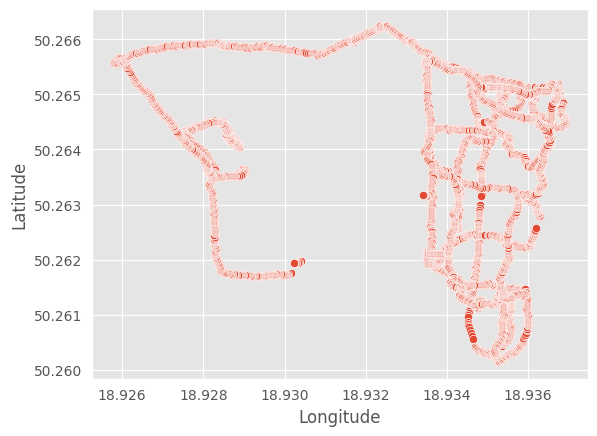

In [5]:
sns.scatterplot(x='Longitude', y='Latitude', data=df)

  0%|          | 0/4991 [00:00<?, ?it/s]

  0%|          | 0/4991 [00:00<?, ?it/s]

  0%|          | 0/4991 [00:00<?, ?it/s]

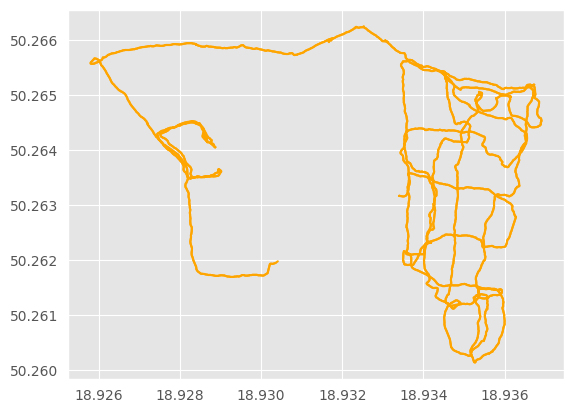

In [8]:
pg = NaivePointsGraph(20)
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    pg.insert_vertex(row['Longitude'], row['Latitude'])
vx, vy = pg.list_vertices()

last_long, last_lat = None, None
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    long, lat = row['Longitude'], row['Latitude']
    if last_long is not None:
        pg.insert_edge(last_long, last_lat, long, lat)
    last_long, last_lat = long, lat

last_long, last_lat = None, None
oex1, oey1, oex2, oey2 = [], [], [], []
for index, row in tqdm(df.iterrows(), total=df.shape[0]):
    long, lat = row['Longitude'], row['Latitude']
    if last_long is not None:
        oex1 += [last_long]
        oey1 += [last_lat]
        oex2 += [long]
        oey2 += [lat]
    last_long, last_lat = long, lat
plt.plot(oex1, oey1, oex2, oey2, c='orange')

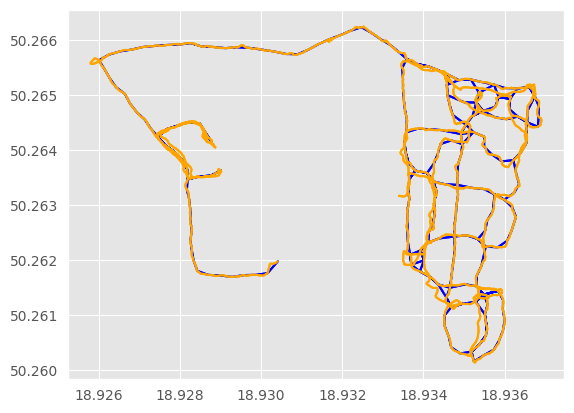

In [9]:
ex1, ey1, ex2, ey2 = pg.list_edges()
plt.plot(ex1, ey1, ex2, ey2, c='blue')
plt.plot(oex1, oey1, oex2, oey2, c='orange')

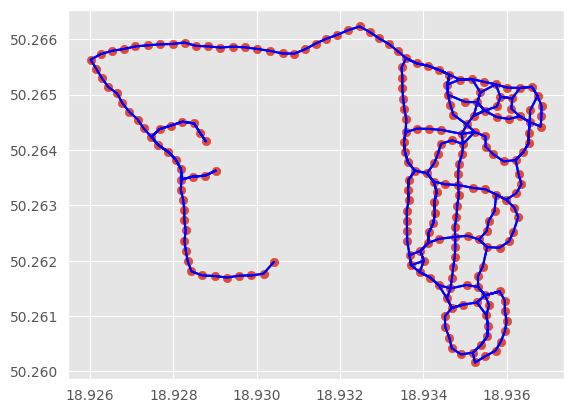

In [10]:
plt.plot(ex1, ey1, ex2, ey2, c='blue')
plt.scatter(vx, vy)
